# Clustering Routine

This Jupyter Notebook can be ran after the initial crawling with the *crawl.py* python script to categorize a big number of news articles by their topics. The duration of the Jupyter Notebook processing time may vary depending on your dataset size. You can estimate at least a few hours for datasets bigger than 50 000 articles.

# Routine Of The Jupyter Notebook

This algorithm can be structured into the following main components:

1. Load crawled dataset from the folder *./crawl_json/*.
2. Preprocessing.
3. Visualize the data with wordclouds.
4. LDA Clustering.
5. Find the optimal amount of clusters with the coherence score.
6. Visualize the optimal topic clusters with LDAvis.
7. Subcluster all news articles by their release date.
8. Sort all documents into a folder hierarchy *./clustered_json/* to represent the cluster topics.


# Open Data From JSON
First we have to load our previously cralwed dataset into memory.

In [10]:
import pandas as pd
import numpy as np
import os
import glob

In [11]:
path = 'crawl_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


# Amount of articles that will be processed:

In [12]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 1659


# Preprocessing 

We will now continue with preparing the data for the actual clustering. Therefore we are lemmatizing all strings and removing all words that aren't nouns.

In [13]:
import re

In [14]:
df['id'] = df.index
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2


In [15]:
# Remove punctuation
df['maintext_prepro'] = \
df['maintext'].map(lambda x: re.sub('[,\.!?]', '', x))
# To lowercase
df['maintext_prepro'] = \
df['maintext_prepro'].map(lambda x: x.lower())

In [16]:
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
is_noun = lambda pos: pos[:2] == 'NN'
nouns = []

stemmer = WordNetLemmatizer()

estimated_minutes = amount_of_articles * 0.000217

print(f'Tokenizing all articles. This may take a while. (Estimate: ~{ round(estimated_minutes, 2) } minutes)')
df['tokenized_words'] = df['maintext'].apply(nltk.word_tokenize)
print("Finished tokenizing all articles. Continue with lemmatization & noun extraction.")


Tokenizing all articles. This may take a while. (Estimate: ~0.36 minutes)
Finished tokenizing all articles. Continue with lemmatization & noun extraction.


In [18]:
print("Lemmatization & noun extraction is running...")
for element in tqdm(df["tokenized_words"]):
	nouns.append(" ".join([stemmer.lemmatize(word) for (word, pos) in nltk.pos_tag(element) if is_noun(pos) and len(word) > 2]))    # joined as a single string per article

print("Finished lemmatization & noun extraction.")
df["maintext_nouns"] = nouns

  0%|          | 0/1659 [00:00<?, ?it/s]

Lemmatization & noun extraction is running...


100%|██████████| 1659/1659 [02:10<00:00, 12.70it/s]

Finished lemmatization & noun extraction.


In [19]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...


# Word Cloud

The following word clouds will give you a general idea about how each step in preprocessing improves the quality of the dataset for our use case. The bigger a word is shown, the more frequent is its existence in our dataset. 

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Word Cloud All Words

This word cloud includes all words of the articles without major filtering.

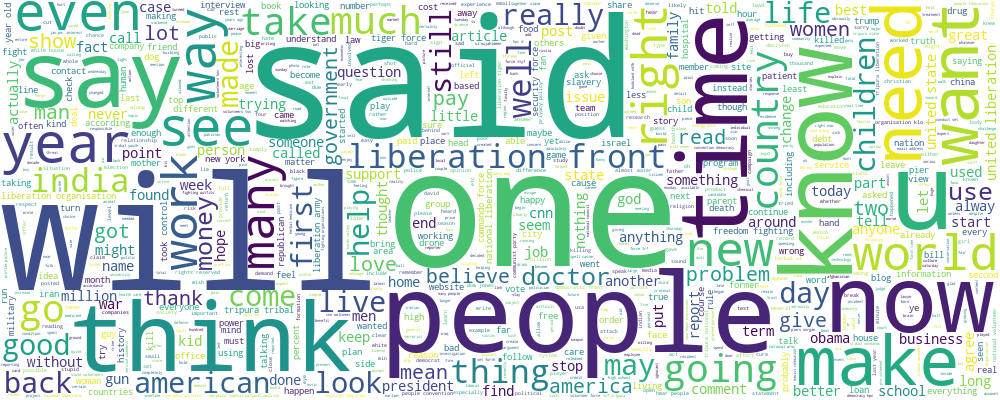

In [21]:
all_articles_string = ','.join(list(df['maintext_prepro'].values))
wordcloud.generate(all_articles_string)

wordcloud.to_image()

# Word Cloud Only Nouns

This word cloud shows you only the nouns of the acticles.

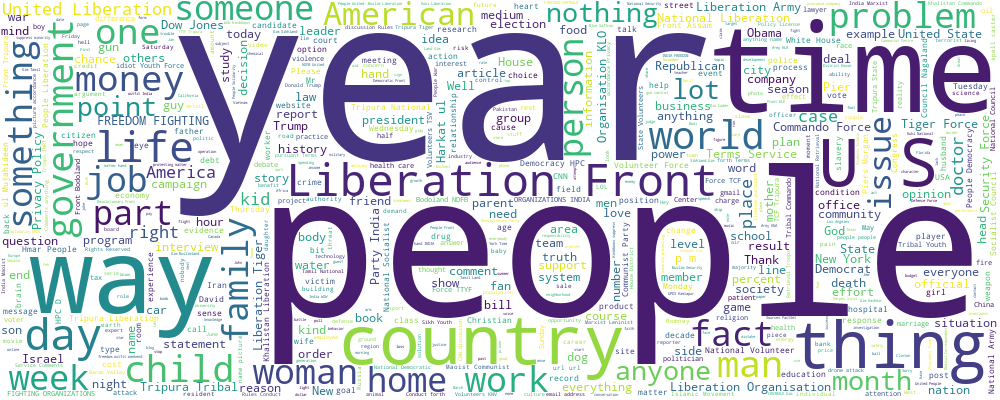

In [22]:
all_articles_nouns = ','.join(list(df['maintext_nouns'].values))
wordcloud.generate(all_articles_nouns)

wordcloud.to_image()

# Prepare data for LDA analysis

We will continue preparing our data for the LDA clustering by removing predefined stopwords (extended by *./stopwords.json*) and filtering out unwanted characters.

In [23]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import json
import regex

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
stop_words = stopwords.words('english')

with open("stopwords.json") as jsonFile:
    jsonStopwords = json.load(jsonFile)

#extend stopwords if desired
stop_words.extend(jsonStopwords)  


In [25]:
#Tokenize Text
def sentence_to_words(sentences):
    for sent in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sent, deacc=True))

In [26]:
#Remove Stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words)] for doc in texts]    #filtering

In [27]:
#Remove non alphanumeric words
def remove_non_alphanumeric(texts):
    return [[word for word in list if word.isalnum()] for list in texts]

In [28]:
def remove_non_ASCII(lists):
    for list in lists:
        for i, string in enumerate(list):
            if string.isascii():
                continue
            else:
                list.pop(i)
    return lists

In [29]:
maintext_data = df["maintext_nouns"].values.tolist()
df["maintext_ready"] = list(sentence_to_words(maintext_data))

maintext_ready = remove_stopwords(df["maintext_ready"].tolist())
maintext_ready = remove_non_ASCII(maintext_ready)
df["maintext_ready"]  = maintext_ready

In [30]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,..."


# Wordcloud of the ready-to-cluster articles

This is the word cloud of the dataset which we will actually apply out LDA clustering on.

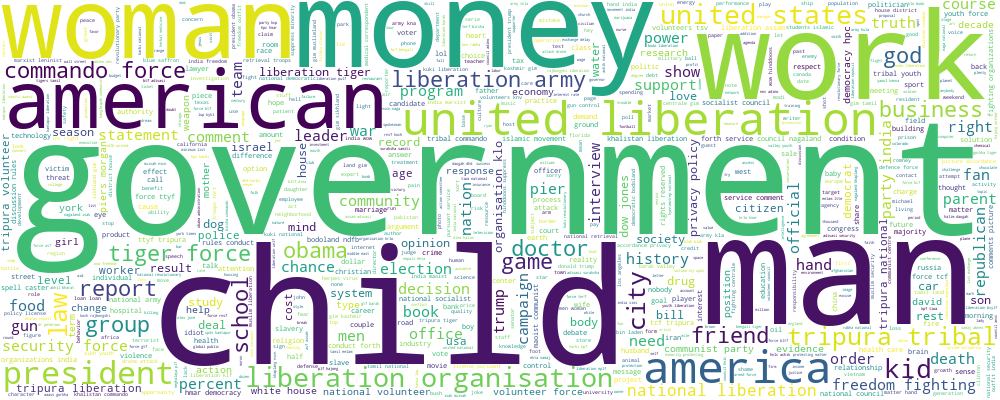

In [31]:
ready_wordlist = []
for element in df["maintext_ready"]:
    ready_wordlist.append(','.join(list(element)))

all_articles_ready = ','.join(ready_wordlist)
wordcloud.generate(all_articles_ready)

wordcloud.to_image()

# Create the Corpus

Creating a corpus is needed to have data that is understandable to gensim. This will be given to the LDA algorithm to perform the clustering.

In [32]:
import gensim.corpora as corpora

In [33]:
data = df["maintext_ready"].tolist()

word_dictionary = corpora.Dictionary(data)

corpus = [word_dictionary.doc2bow(text) for text in data]   #create the corpus

df["corpus"] = corpus

In [34]:
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(2, 16), (19, 1), (33, 1), (63, 16), (68, 1),..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(10, 4), (15, 1), (19, 1), (21, 1), (33, 1), ..."


# Build a LDA model & calculate Coherence Score

The following code is going through a prefined range of topic amounts to check which clustering approach suits the dataset best. Each iteration inlcludes the clustering of all articles and the calculation of the coherence score. A sudden drop in the coherence score will trigger an early stopping. The algorithm will continue with taking the best possible clusters from there on.

In [35]:
from pprint import pprint   #pretty printing
from gensim.models import CoherenceModel

In [36]:
topic_amount_start = 30     #specify where to start generating clusters
topic_amount_end = 300      #specify the maximum amount of clusters
iteration_interval = 10     
elbow_tolerance = 0.003     #specify how sensitive the elbow method should trigger.

In [47]:
amount_of_topics = 0
best_coherence = 0

print(f"Calculating the optimal amount of clusters inbetween {topic_amount_start} and {topic_amount_end}.")

#Find the best possible coherence value inbetween the given min and max amount of articles. Continue with the best lda model found.
for amount_of_topics in range(topic_amount_start, topic_amount_end, iteration_interval):   
    lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = word_dictionary, num_topics = amount_of_topics, alpha=0.1, eta=0.3)   #build the LDA model

    cm = CoherenceModel(model=lda_model, texts=df["maintext_ready"].tolist(), dictionary=word_dictionary, coherence='c_v')     #calculate coherence
    coherence = cm.get_coherence()
    print(f"Coherence with {amount_of_topics} topics: ", coherence)

    if ( coherence < (best_coherence - elbow_tolerance) ):     #elbow stopping
        print(f"Early stopping tolerance of {elbow_tolerance} met. Stopping to look at higher amounts of clusters because a sudden drop in clustering quality was detected.")
        break

    if (coherence > best_coherence):    #if the new coherence is better than before, save it as a new best.
        print("New best!")
        best_lda_model = lda_model
        best_coherence = coherence
        best_amount = amount_of_topics

print(f"Finished! Continuing with {best_amount} topic clusters. Coherence: {best_coherence}")


C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculating the optimal amount of clusters inbetween 30 and 300.


KeyError: 'maintext_ready'

# Displaying the LDA model

This is the built LDA model. The first number represents the cluster ID. The other part shows you the propablity of words in the specific topic.

In [ ]:
pprint(best_lda_model.print_topics())
articles_lda = best_lda_model[corpus]

[(25,
  '0.003*"war" + 0.003*"government" + 0.003*"right" + 0.003*"force" + '
  '0.002*"doctor" + 0.002*"child" + 0.002*"israel" + 0.002*"school" + '
  '0.002*"woman" + 0.002*"iran"'),
 (28,
  '0.009*"doctor" + 0.005*"school" + 0.003*"loan" + 0.003*"child" + '
  '0.003*"money" + 0.003*"woman" + 0.003*"house" + 0.003*"insurance" + '
  '0.003*"work" + 0.002*"district"'),
 (14,
  '0.006*"child" + 0.006*"gun" + 0.005*"district" + 0.003*"government" + '
  '0.003*"woman" + 0.003*"war" + 0.003*"obama" + 0.003*"assembly" + '
  '0.003*"man" + 0.003*"money"'),
 (7,
  '0.009*"liberation" + 0.009*"force" + 0.007*"tripura" + 0.006*"national" + '
  '0.005*"united" + 0.005*"india" + 0.004*"council" + 0.003*"khalistan" + '
  '0.003*"party" + 0.003*"school"'),
 (1,
  '0.007*"national" + 0.007*"liberation" + 0.007*"tripura" + 0.006*"force" + '
  '0.004*"india" + 0.003*"united" + 0.003*"woman" + 0.003*"president" + '
  '0.003*"obama" + 0.002*"money"'),
 (27,
  '0.006*"child" + 0.005*"trump" + 0.004*"pres

# Visualize the LDA model

This visualization is interactable and helps you identifying the quality of the LDA clustering by hand.

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
from IPython.display import HTML, display

pyLDAvis.enable_notebook()

In [ ]:
LDAvis_data_filepath = os.path.join('./lda_results/ldavis_data_'+str(amount_of_topics)+'topics')

LDAvis_prepared = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, word_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

#load pre-prepared pyLDAvis data
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_data = pickle.load(f)
pyLDAvis.save_html(LDAvis_data, './lda_results/ldavis_data_'+ str(amount_of_topics) +'topics.html')
LDAvis_data #show the data

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.033715  0.019347       1        1  17.665996
23     0.087808  0.009135       2        1  12.431926
39    -0.001884  0.007636       3        1   7.585567
19     0.006395 -0.002582       4        1   4.292337
38    -0.024523 -0.001402       5        1   4.154610
27    -0.016814  0.010640       6        1   3.918905
13    -0.015206 -0.002796       7        1   3.705576
11    -0.034554 -0.013465       8        1   3.608279
21    -0.004711  0.006707       9        1   3.268753
28    -0.026274 -0.015735      10        1   2.690780
2     -0.010209 -0.004467      11        1   2.450635
8      0.018139  0.006854      12        1   2.353689
12    -0.006536  0.000607      13        1   2.257914
3     -0.005453  0.005421      14        1   2.125101
34    -0.018965  0.007696      15        1   1.963761
31    -0.005885  0.003730      16        1   1.826330
16    -0.021129  0.000847      17        1   1.790558
4     -0.025602  0.005312      18        1   1.777350
5      0.002050 -0.007901      19        1   1.599230
6     -0.008000 -0.006889      20        1   1.585563
0     -0.022603  0.004892      21        1   1.577352
22     0.046764 -0.001741      22        1   1.220348
29     0.018385  0.007137      23        1   1.193973
20    -0.031898 -0.005109      24        1   1.123314
26     0.001637 -0.002554      25        1   1.085719
32    -0.016238 -0.001859      26        1   1.000975
37     0.040509 -0.002740      27        1   0.961971
35     0.005161  0.005078      28        1   0.930085
7      0.025511 -0.003575      29        1   0.913351
36     0.019853 -0.005634      30        1   0.817350
24    -0.010538 -0.002786      31        1   0.728081
30    -0.001250 -0.003015      32        1   0.701694
1      0.018798 -0.000016      33        1   0.686093
25    -0.016803  0.003860      34        1   0.660477
15     0.036092  0.005241      35        1   0.651279
33     0.014544  0.000017      36        1   0.623641
9      0.013135  0.003819      37        1   0.598258
10     0.049093 -0.019315      38        1   0.593378
17    -0.031359 -0.002275      39        1   0.447043
18    -0.013727 -0.008119      40        1   0.432760, topic_info=           Term         Freq        Total Category  logprob  loglift
248       force  4413.000000  4413.000000  Default  30.0000  30.0000
349  liberation  3640.000000  3640.000000  Default  29.0000  29.0000
491     tripura  3009.000000  3009.000000  Default  28.0000  28.0000
383    national  2676.000000  2676.000000  Default  27.0000  27.0000
285       india  2888.000000  2888.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
383    national     6.114971  2676.091576  Topic40  -6.2758  -0.6386
349  liberation     6.610982  3640.215230  Topic40  -6.1978  -0.8683
285       india     6.090805  2888.355064  Topic40  -6.2798  -0.7189
491     tripura     5.011234  3009.505304  Topic40  -6.4749  -0.9551
13     business     4.390752  1107.729602  Topic40  -6.6071  -0.0878

[3099 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
9443       1  0.121019  abortion
9443       2  0.083783  abortion
9443       3  0.074473  abortion
9443       4  0.037237  abortion
9443       5  0.027928  abortion
...      ...       ...       ...
42707      5  0.245478     بلاير
42707      7  0.122739     بلاير
42718      1  0.153461      فلاش
42718      3  0.153461      فلاش
42718      5  0.153461      فلاش

[22666 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 24, 40, 20, 39, 28, 14, 12, 22, 29, 3, 9, 13, 4, 35, 32, 17, 5, 6, 7, 1, 23, 30, 21, 27, 33, 38, 36, 8, 37, 25, 31, 2, 26, 16, 34, 10, 11, 18, 19])

# Store Cluster IDs to dataframe

To be able to correctly sort all articles into a floder hierachy wee need to store each articles cluster id into the dataframe.

In [ ]:
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

lda_topics = best_lda_model.show_topics(num_words=5)
for topic in lda_topics:
    print(topic)
    topics.append(preprocess_string(topic[1], filters))

(39, '0.007*"india" + 0.005*"child" + 0.004*"force" + 0.003*"government" + 0.003*"united"')
(14, '0.006*"child" + 0.006*"gun" + 0.005*"district" + 0.003*"government" + 0.003*"woman"')
(15, '0.012*"liberation" + 0.010*"tripura" + 0.009*"national" + 0.009*"force" + 0.005*"united"')
(24, '0.004*"child" + 0.003*"india" + 0.003*"liberation" + 0.002*"government" + 0.002*"force"')
(30, '0.005*"force" + 0.004*"house" + 0.003*"liberation" + 0.003*"national" + 0.003*"woman"')
(35, '0.006*"force" + 0.004*"national" + 0.004*"liberation" + 0.003*"united" + 0.003*"woman"')
(29, '0.008*"liberation" + 0.007*"force" + 0.007*"tripura" + 0.006*"india" + 0.005*"united"')
(33, '0.006*"liberation" + 0.006*"force" + 0.005*"united" + 0.005*"national" + 0.004*"india"')
(31, '0.004*"india" + 0.004*"liberation" + 0.003*"force" + 0.003*"president" + 0.003*"obama"')
(28, '0.009*"doctor" + 0.005*"school" + 0.003*"loan" + 0.003*"child" + 0.003*"money"')


C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_list = []
topic_percentage_list = []
topic_keywords_list = []

print(len(df))
for row in tqdm(articles_lda):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topic_num = row[0][0]
    prop_topic = row[0][1]

    wp = best_lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    topic_list.append(int(topic_num))
    topic_percentage_list.append(round(prop_topic,5))
    topic_keywords_list.append(topic_keywords)


df["clusterID"] = topic_list    ##the id of the topic
df["topic_percentage"] = topic_percentage_list  #how well the topic fits to this specifc article
df["topic_keywords"] = topic_keywords_list  #the dominant keywords for the topic

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  1%|          | 14/1659 [00:00<00:12, 132.07it/s]

1659


100%|██████████| 1659/1659 [00:14<00:00, 114.53it/s]


In [ ]:
df.head(3)

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,id,maintext_prepro,tokenized_words,maintext_nouns,maintext_ready,corpus,clusterID,topic_percentage,topic_keywords
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,0,editor's note: anderson cooper explains why a ...,"[Editor, 's, note, :, Anderson, Cooper, explai...",Editor note Anderson Cooper t-shirt retailer J...,"[editor, note, anderson, cooper, shirt, retail...","[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1...",27,0.58987,"child, trump, president, money, war, school, m..."
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,1,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(2, 16), (19, 1), (33, 1), (63, 16), (68, 1),...",23,0.99682,"force, liberation, tripura, national, united, ..."
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,2,for the latest updates to global public square...,"[For, the, latest, updates, to, Global, Public...",update Global Public Square show information F...,"[update, global, public, square, show, fareed,...","[(10, 4), (15, 1), (19, 1), (21, 1), (33, 1), ...",39,0.73704,"india, child, force, government, united, god, ..."


# Output LDA clustering to json files


In [ ]:
df = df.drop(columns=["maintext_prepro", "tokenized_articles", "maintext_nouns", "corpus", "id"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.

filtered_maintext = [ " ".join(row["maintext_ready"]) for index, row in df.iterrows() ]   

df["filtered_maintext"] = filtered_maintext

df = df.drop(columns=["maintext_ready", "tokenized_words"])

df.head()

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url,clusterID,topic_percentage,topic_keywords,filtered_maintext
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...,27,0.58987,"child, trump, president, money, war, school, m...",editor note anderson cooper shirt retailer jcp...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,23,0.99682,"force, liberation, tripura, national, united, ...",update global public square show fareed take g...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,39,0.73704,"india, child, force, government, united, god, ...",update global public square show fareed take g...
3,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 15:53:08",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,39,0.91971,"india, child, force, government, united, god, ...",update global public square show fareed take g...
4,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 17:20:20",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...,11,0.77366,"doctor, child, loan, school, india, service, a...",update global public square show fareed take g...


# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

In [ ]:
import ujson

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.reset_index(drop=True,inplace=True)

for cluster_id, data in df.groupby(df.clusterID):
    item = data.topic_keywords.iloc[0].split(",")
    with open(f'./lda_clustered_json/cluster_{cluster_id}-{item[0]}_{item[1]}_{item[2]}.json', 'w', encoding='utf-8') as f:
        f.write(ujson.dumps(data.to_dict('index'), indent=4, ensure_ascii=False, escape_forward_slashes=False))

C:\Users\Nicolas\anaconda3\envs\kcc\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
